# Customer Segmentation
The objective of this work is to cluster customers into segments using Unsupervised Learning. The data will be analyzed through Exploratory Data Analysis (EDA), cleaned and various types of unsupervised algorithms will be applied to cluster the segments. 

The github for this work will be found: https://github.com/suchig/DTSA-5510

## Data
The data used is from https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

Data Fields:
1. Customer ID - Unique Identification of Customers
2. age - Age of customer
3. gender - Gender of Customer (Male or Female)
4. Annual Income - Income in K$
5. Spending score - Score depicting how much Customer spends - Between 1 to 100. 

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from sklearn.cluster import DBSCAN 
from sklearn.metrics import silhouette_score

import warnings

warnings.filterwarnings('ignore')

Below shows a sample of data

In [4]:
customer_df = pd.read_csv('../input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')
customer_df = customer_df.rename(columns={'Annual Income (k$)': 'Income',
                              'Spending Score (1-100)': 'Score'})
customer_df.head()

,CustomerID,Gender,Age,Income,Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## EDA

Here we will examine details of data, identify opportunities to clean up or understand the data better

In [5]:
print(f"Total number of rows {len(customer_df)}")

Total number of rows 200


From below we see that there is no null data

In [6]:
#Below code checks if any column has null value
customer_df.isnull().sum()

CustomerID    0
Gender        0
Age           0
Income        0
Score         0
dtype: int64

From below we see that there is no null data

In [7]:
#Drop all rows that have null values
customer_df.dropna(inplace=True)
print(f"Number of rows after removing NA: {len(customer_df)}")

Number of rows after removing NA: 200


From below we see that all data types are correct

In [8]:
#To check if right types are assigned
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  200 non-null    int64 
 1   Gender      200 non-null    object
 2   Age         200 non-null    int64 
 3   Income      200 non-null    int64 
 4   Score       200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


### Data Exploration

#### Is there any data imbalance?
We see that data distribution between Gender "Male" and "Female" are balanced

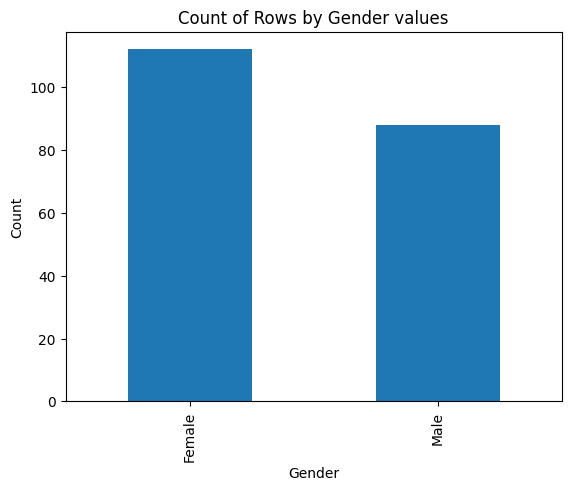

In [9]:
#Plot and visualize count of  target values by 0s and 1s 
customer_df["Gender"].value_counts().plot(kind="bar", xlabel="Gender", ylabel="Count",title="Count of Rows by Gender values");

#### How is the distribution of numerical data looking?
Drawing histograms of numerical columns, we can see that most of them have a good distribution of data. Income seems to be skewed towards the tail end but from a proportion standpoint it is not a heavy skew

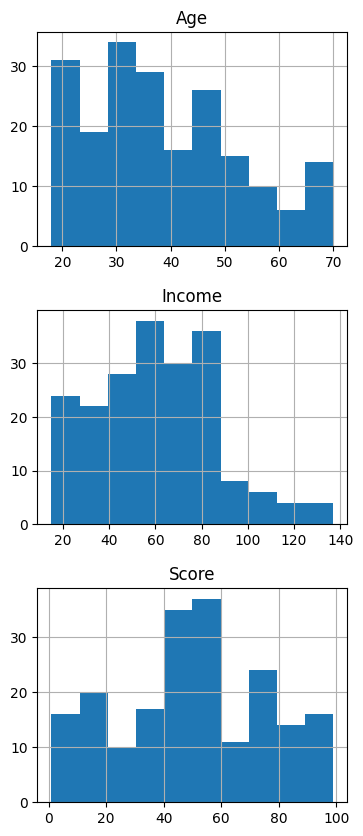

In [10]:
num_columns = ["Age", "Income", "Score"]

#Visualize each numerical column's distribution
fig, axs = plt.subplots(3, 1, figsize=(4, 10))
for ax, col in zip(axs.flatten(), num_columns):
    customer_df.hist(column=col, ax=ax)

#### How are the numerical values correlated?
Through correlation matrix we see that 
1. None of the fields have a strong corelation greater than 33%
2. Age and Score are negatively correlated around 33%. That is not a significant correlation

There is no strong indication to remove any of the values as corelation is weak

<Axes: >

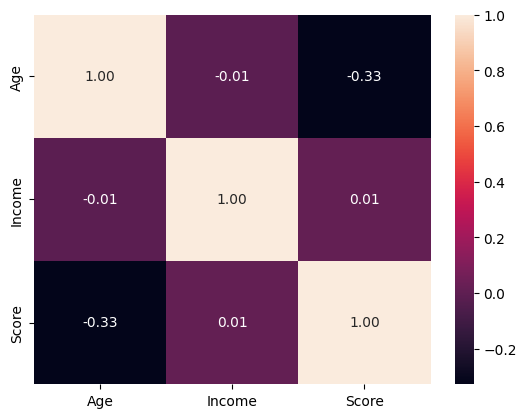

In [11]:
#Heatmap of numerical columns correlation with each other and target
sns.heatmap(customer_df[num_columns].corr(), annot=True, fmt=".2f")

#### How correlated are the features through pairplot?
 - We observe from below that the numerical features (age, Income and Score) are not very correlated. That is there is no need to eliminate any of them. 
 - Also we see that the data is well distributed across genders. 

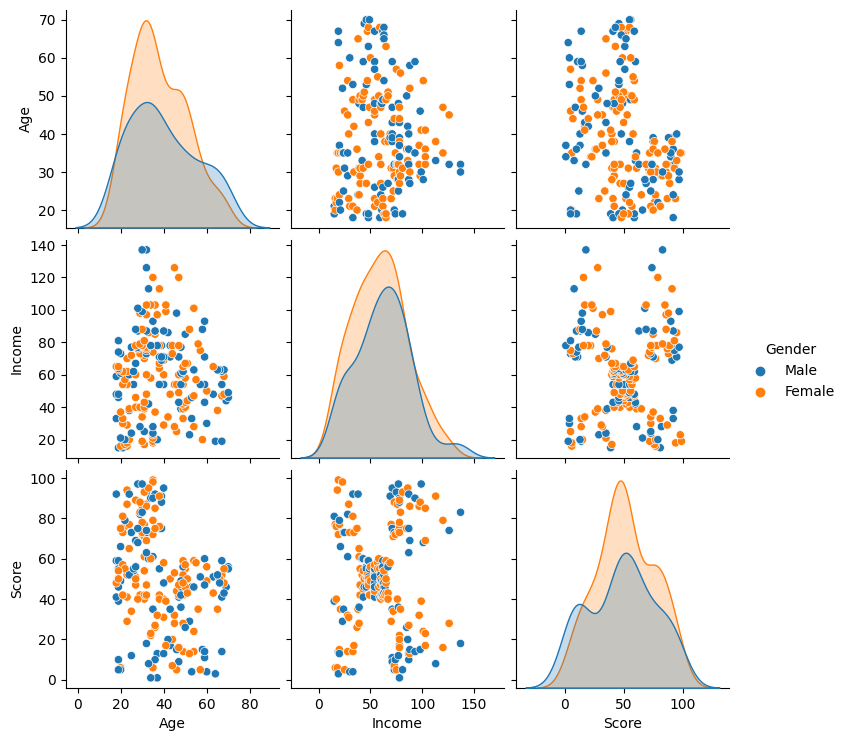

In [12]:
sns.pairplot(customer_df.drop(columns="CustomerID"), hue='Gender')

### Summary of EDA and Data Cleaning
- We observed that the data is well distributed
- The data os clean with no nulls or extreme outliers as seen from plots

## Models
Plan to employ the following models
- KMeans 
- Agglomerate 
- DBScan

### Feature Engineering
1. We will convert String values of Gender into 0 and 1 as part of Feature Engineering
2. We will drop Gender (as we have Gender Code as part of above step) and Customer id

In [13]:
customer_df["Gender_Code"] = [0 if item == "Male" else 1 for item in customer_df["Gender"]]
clean_customer_df = customer_df.drop(columns=["CustomerID", "Gender"])

### KMeans

We start by identifying number of clusters through Elbow method. Then we examine the clusters to see if there is any eaningful interpretation

#### Identification of number of clusters

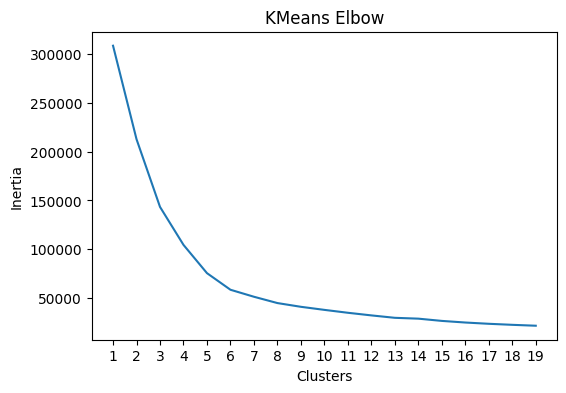

In [14]:
clusters = []

for i in range(1, 20):
    km = KMeans(n_clusters=i).fit(clean_customer_df)
    clusters.append(km.inertia_)
    
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(x=list(range(1, 20)), y=clusters, ax=ax)
ax.set_xticks(list(range(1, 20)))
ax.set_title('KMeans Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia');

From above both cluster 5 and cluster 6 look like elbow. So we will try and see which ones make sense by plotting Income vs Score chart and identifying if there is any pattern for these clusters.

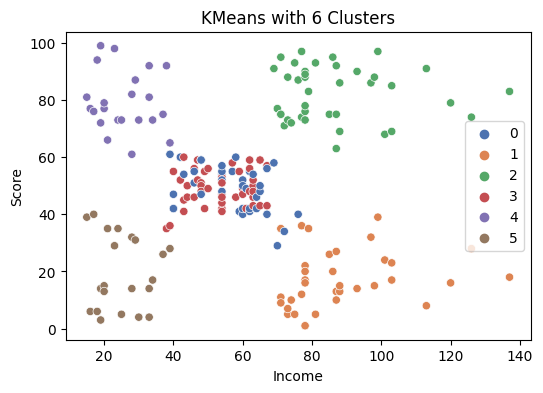

In [15]:
km6_model = KMeans(n_clusters=6).fit(clean_customer_df)

plt.figure(figsize=(6, 4))
sns.scatterplot(data = clean_customer_df, x='Income', y='Score', hue=km6_model.labels_, 
                palette="deep")
plt.title('KMeans with 6 Clusters');

From above we see that Cluster 6 has some mish mash of data between 3 and 0. 

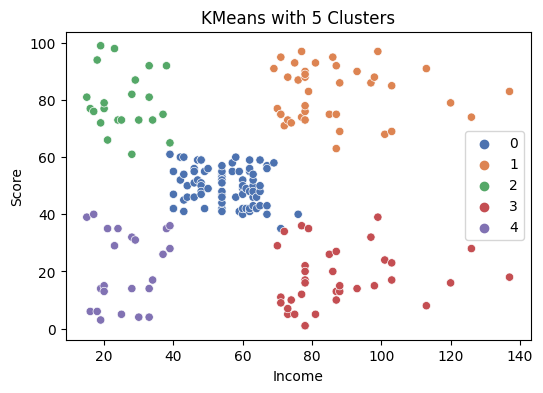

In [16]:
km5_model = KMeans(n_clusters=5).fit(clean_customer_df)

plt.figure(figsize=(6, 4))
sns.scatterplot(data = clean_customer_df, x='Income', y='Score', hue=km5_model.labels_, 
                palette="deep")
plt.title('KMeans with 5 Clusters');

As seen above, Income vs Score for 5 clusters gives a distinct pattern. Suppose this pattern did not emerge, we would have continued to look at other columns to find a satisfactory results.

**Interpretation of labels**
- 0: Medium Income and Medium Spending Score
- 1: High Income and High Spending Score
- 2: Low Income and High Spending Score
- 3: High Income Low Spending Score
- 4: Low Income and Low Spending Score

#### Interpretation of results

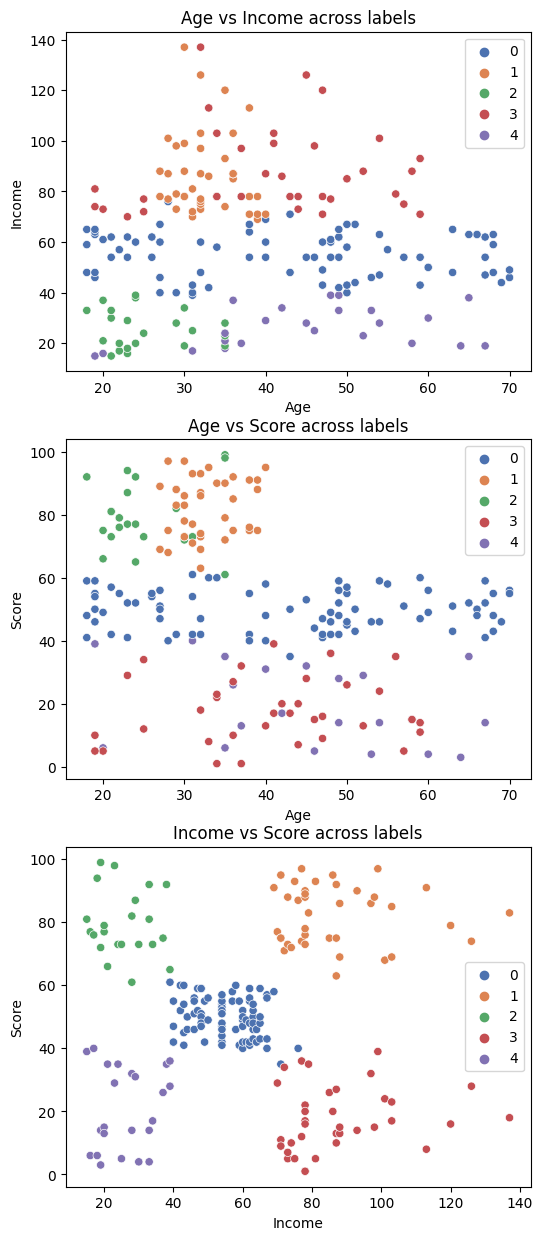

In [19]:
combinations = [item for item in itertools.combinations(["Age", "Income", "Score"],2)]
fig, axs = plt.subplots(len(combinations), 1, figsize=(6, 15))
for ax, col in zip(axs.flatten(), combinations):
    sns.scatterplot(data = clean_customer_df, x=col[0], y=col[1], hue=km5_model.labels_, 
                    palette="deep", ax=ax)
    ax.set_title(f'{col[0]} vs {col[1]} across labels');

Some observations:
1. Low Income High Spending Score people are usually relatively younger (< 30)
2. Low Income Low Spending score are those who are relatively older (> 30)
3. High Income and High Spending Score are between 30 to 40

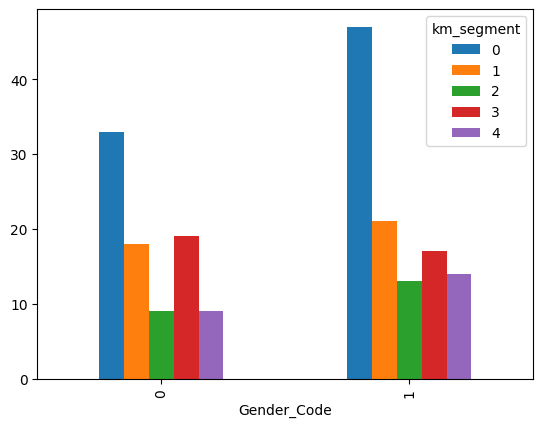

In [20]:
clean_customer_df["km_segment"] = km5_model.labels_
clean_customer_df.groupby("Gender_Code")["km_segment"].value_counts().unstack("km_segment").plot.bar();

We see from above that pattern of spending and income is same across Male and Female

### Agglomerative Clustering
Here we will use cluster number 5 to identify how Agglomerative clustering groups segments

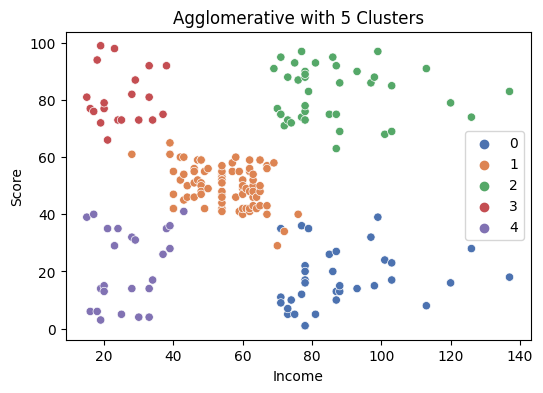

In [21]:
X = clean_customer_df.drop(columns="km_segment")
ag_model = AgglomerativeClustering(n_clusters=5, linkage='average').fit(X)
plt.figure(figsize=(6, 4))
sns.scatterplot(data = clean_customer_df, x='Income', y='Score', hue=ag_model.labels_, 
                palette="deep")
plt.title('Agglomerative with 5 Clusters');

The clusters are very similar to what we saw in KMeans. The labels are a little different but their interpretation is same.

- 0: High Income and Low Spending Score (KM equivalent: 3)
- 1: Medium Income and Medium Spending Score (KM equivalent: 0)
- 2: High Income and High Spending Score (KM equivalent: 1)
- 3: Low Income High Spending Score (KM equivalent: 2)
- 4: Low Income and Low Spending Score (KM equivalent: 4)

Also, we observe overlap of 0, 1 and 3

#### Dendogram
A simplified version of dendogram is displayed below. That is instead of displaying all possible clusters, we will be displaying only 15 clusters for readability

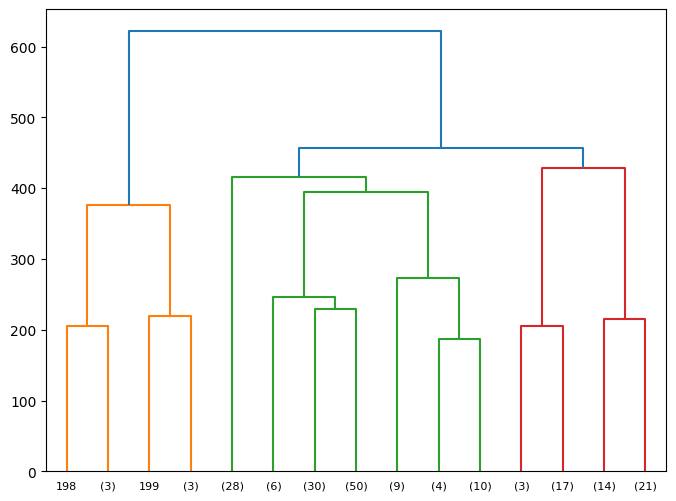

In [22]:
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 

X = clean_customer_df.drop(columns="km_segment")
dist = distance_matrix(X, X)
Z = hierarchy.linkage(dist, 'average')
plt.figure(figsize=(8, 6))
dendro = hierarchy.dendrogram(Z, p=15, truncate_mode = 'lastp', leaf_rotation=0, leaf_font_size =8)

We can see from above that at a distance of 400, 5 clusters are made, which is the result of our Agglomerative Clustering

### DBScan
This is a model that was not taught in the course, but is very popular. DBScan is an algorithm that clusters based on density or number of points within a specified radius. This could be used to identify clusters that have non traditional shapes like donut shape.

DBScan provides a -1 value as a cluster to denote noise. That is points that are outside the cluster and acts like frivilous noise or oitlier. Our objective is to reduce this and yet keep our total number of clusters as 5.

Below steps are carried out for DBScan
1. Identify eps or radius that will give us best result with minimum noise
2. Identify min_sample or minimum number of sample to be within a radius to deem it as a cluster (with minimum noise)
3. Strive for 5 custers

In [23]:
select_eps = 0
select_min_sample = 0
min_noise = 1000
for eps in range (1,30):
    for min_sample in range(1, 30):
        db_model = DBSCAN(eps=eps,min_samples=min_sample).fit(X)
        labels = db_model.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        if n_clusters == 5 and min_noise > n_noise:
            min_noise = n_noise
            select_eps = eps
            select_min_sample = min_sample
print(f"eps {select_eps} and min_sample {select_min_sample} has minimum noise items {min_noise}")

eps 12 and min_sample 5 has minimum noise items 37


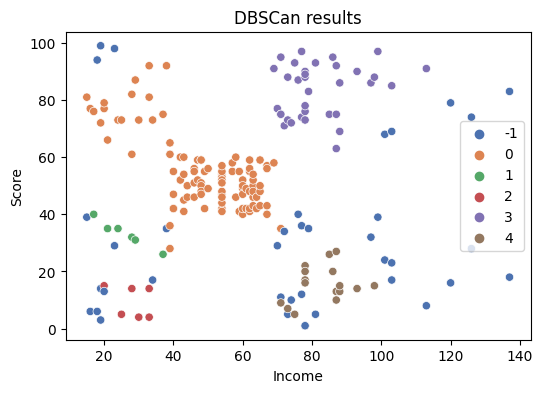

In [24]:
db_model = DBSCAN(eps=select_eps,min_samples=select_min_sample).fit(X)

plt.figure(figsize=(6, 4))
sns.scatterplot(data = clean_customer_df, x='Income', y='Score', hue=db_model.labels_, 
                palette="deep")
plt.title('DBSCan results');

From the above we see that there is significant overlap between points in clusters and there are 37 points with noise. DB Scan may not be the best solution for this use case since it has clear cut clustering

### Assessment of results

Results are assessed using Silhouette Score. The Silhouette Coefficient defined as:

$$ \frac{(b-a)}{max(a,b)} $$

where:\
a: The mean distance between a sample and all other points in the same class.\
b: The mean distance between a sample and all other points in the next nearest cluster.

Coefficient can be between -1 and 1, 1 being the better value


In [174]:
print("Silhouette Score of KMeans with 5 clusters:",silhouette_score(X, km5_model.labels_))
print("Silhouette Score of Agglomerative with 5 clusters:",silhouette_score(X, ag_model.labels_))
print("Silhouette Score of DBScan with 5 clusters:",silhouette_score(X, db_model.labels_))

Silhouette Score of KMeans with 5 clusters: 0.4440669204743008
Silhouette Score of Agglomerative with 5 clusters: 0.43521075902386996
Silhouette Score of DBScan with 5 clusters: 0.17636596403359894


From above, we see that KMeans has better coefficient than other methods

## Summary
 Below is the summary of this analysis and lessons learned
 
 1. This example is a simple one. The more complex our example becomes, we will need PCA to reduce dimensions. In real world, customer segmentation will possess much more features
 2. It may not be easy to define the clusters in a semantic way. since this example was easier, I was able to bring this interpretation with Income and Spending score. In real world, it could involve more dimensions and may not be easily interpretable
 3. The choice of algorithm will depend on complexity of use case. Even though DBScan did not prove to be a useful one here, it could be very beneficial if the use case gets more complex
 4. It would be benficial to have a true label from experts so we will know if we are in right direction. Here this was very difficult to build

## References
1. https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
2. https://scikit-learn.org/stable/modules/clustering.html#dbscan
3. https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/